## **0. 사전 설치 리스트**

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install graphviz
    # 한글 깨짐 방지
    !sudo apt-get install -y fonts-nanum 
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

In [1]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [28]:
import sklearn
import xgboost
import pandas as pd
import eli5
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OrdinalEncoder, TargetEncoder, HelmertEncoder
from eli5.sklearn import PermutationImportance
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot

## **1. 최종 데이터 및 모델 불러오기**

In [4]:
# 경로 설정
final_data_url = '/content/drive/MyDrive/Colab Notebooks/Codestate_AI/Session2/Example_data/session2_project/final_data.csv'

# 불러오기
final_data = pd.read_csv(final_data_url, sep=',')

# 형태 확인
final_data.shape

(72656, 16)

In [44]:
# target, feature 선언
target = '물의를일으켰는가'
features = final_data.drop(columns=[target]).columns

# train, test 분리
train, test = train_test_split(final_data, train_size=0.80, test_size=0.20, stratify=final_data[target], random_state=2)

# train, test 지정 (feature, target 별)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# 지정 결과 확인 - 굳
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((58124, 15), (58124,), (14532, 15), (14532,))

In [45]:
#변수 선언

#순서 없고 범주형인 Feature - Targetencoder
col_rename_tar = ['성별']

# 각 클래스의 평균에 대한 가중치 반영이 필요하다고 판단되는 Feature - Helmertencoder
col_rename_hel = ['연령대', '허용가능한과속수준(고속도로)']

#순서 있고 범주형인 Feature이고 동일한 간격으로 배치 된 것 - Polynomialencoder
col_rename_pol = ['교통안전중요성', '음주운전인식', '혈중알콜농도강화법안지지도']

#순서 있고 범주형인 Feature이고 동일한 간격으로 배치 된 것 중에서 Mapping 지정할 것 - Polynomialencoder
col_rename_pol_map =[{'col': '교통안전중요성', 'mapping': {'강한 부정': 5, '부정': 4, '모르겠음': 3, '긍정': 2, '강한 긍정': 1}},
                     {'col': '혈중알콜농도강화법안지지도', 'mapping': {'강한 부정': 5, '부정': 4, '모르겠음': 3, '긍정': 2, '강한 긍정': 1}},
                     {'col': '음주운전인식', 'mapping': {'전혀 그렇지 않다': 5, '그렇지 않다': 4, '보통이다': 3, '그렇다': 2, '매우 그렇다': 1}}]          

In [22]:
# 가중치 설정
weight = len(y_train)/(2*np.bincount(y_train))

# 파이프 라인 설정
pipe = make_pipeline(
             TargetEncoder(cols = col_rename_tar),
             HelmertEncoder(cols= col_rename_hel),
             PolynomialEncoder(cols = col_rename_pol, mapping = col_rename_pol_map),
             SimpleImputer(),
             MinMaxScaler(),
             RandomForestClassifier(class_weight={0:weight[0], 1:weight[1]}, random_state=2, n_jobs=-1, oob_score=True)
)

# 파이프 라인 학습
pipe.fit(X_train, y_train);

SyntaxError: ignored

## **2. CV 진행**

In [ ]:
# 최적의 K 찾기 - 교차 검증
k = list(range(2, 13))
for i in k :
        scores = cross_val_score(pipe, X_train, y_train, cv=i, 
        scoring = 'f1')
        print(f'F1 score', scores)
        print(f'F1 score mean', scores.mean())

# K가 13일 때 F1 Score가 최댓값
# 14 ~ 22로 설정하여 진행하였을 때, 13보다 조금 더 높은 값을 도출하는 경우가 있으나 런타임이 끊기는 경우가 있어 13으로 최종 설정

In [21]:
dists = {
    'targetencoder__smoothing': [5.,20.,40.,60.,100.,150.,300.,400.,600.,800.,1000.],
    'targetencoder__min_samples_leaf': randint(1, 20),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': [50, 150, 300, 400, 450, 500], 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, 30, None], 
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 18],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
}

# n_iter(=5) * 13 교차검증 = 65 tasks 수행
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=5, 
    cv=13, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1,
    random_state=2
)

clf.fit(X_train, y_train);
print('최적 하이퍼 파라미터: ', clf.best_params_)
print('F1: ', clf.best_score_)

Fitting 13 folds for each of 5 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed: 65.5min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


최적 하이퍼 파라미터:  {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.6192709663506637, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 450, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 6, 'targetencoder__smoothing': 400.0}
F1:  0.37192759416187265


In [23]:
# 가장 성능이 좋은 것 가져오기
pipe_best = clf.best_estimator_

In [51]:
# 평가지표 확인
y_pred = pipe_best.predict(X_test)

print('테스트 정확도', pipe_best.score(X_test, y_test))
print(classification_report(y_test, y_pred))

테스트 정확도 0.8466831819432975
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     12557
           1       0.42      0.34      0.38      1975

    accuracy                           0.85     14532
   macro avg       0.66      0.63      0.64     14532
weighted avg       0.83      0.85      0.84     14532



## **3. XGboost 진행**

In [52]:
# train+val, test 분리
train_val, test = train_test_split(final_data, train_size=0.80, test_size=0.20, stratify=final_data[target], random_state=2)

# train, val 분리
train, val = train_test_split(train_val, train_size=0.75, test_size=0.25, stratify=train_val[target], random_state=2)

# train, test 지정 (feature, target 별)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# 지정 결과 확인 - 굳
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((43593, 15), (43593,), (14531, 15), (14531,), (14532, 15), (14532,))

In [53]:
# 파이프 라인 설정
pipe_xg = make_pipeline(
             TargetEncoder(cols = col_rename_tar),
             HelmertEncoder(cols= col_rename_hel),
             PolynomialEncoder(cols = col_rename_pol, mapping = col_rename_pol_map),
             SimpleImputer(),
             MinMaxScaler(),
             XGBClassifier(class_weight={0:weight[0], 1:weight[1]}, n_estimators=200, random_state=2, n_jobs=-1, max_depth=7, learning_rate=0.2, oob_score=True)
)

# 파이프 라인 학습
pipe_xg.fit(X_train, y_train);

In [54]:
# 평가지표 확인
y_pred_xg = pipe_xg.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred_xg))
print(classification_report(y_pred_xg, y_val))

검증 정확도:  0.8727548000825821
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14186
           1       0.12      0.68      0.20       345

    accuracy                           0.87     14531
   macro avg       0.56      0.78      0.57     14531
weighted avg       0.97      0.87      0.91     14531



In [55]:
# 파이프라인 재설정
pipe_xg_re = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(cols = col_rename_tar), HelmertEncoder(cols= col_rename_hel), PolynomialEncoder(cols = col_rename_pol, mapping = col_rename_pol_map), SimpleImputer(), MinMaxScaler())),
    ('rf', XGBClassifier(class_weight={0:weight[0], 1:weight[1]}, n_estimators=200, random_state=2, n_jobs=-1, max_depth=7, learning_rate=0.2, oob_score=True))])

# 재학습
pipe_xg.fit(X_train, y_train);

# preprocessing된 X_train, X_val 사용
X_train_transformed = pipe_xg_re.named_steps['preprocessing'].fit_transform(X_train, y_train)
X_val_transformed = pipe_xg_re.named_steps['preprocessing'].transform(X_val)

# scale_pos_weight 비율 산출
vc = y_train.value_counts().tolist() 
ratio = float(vc[0]/vc[1])

# 모델 구축
model = XGBClassifier(n_estimators=1000, max_depth=15, learning_rate=0.3, scale_pos_weight=ratio, n_jobs=-1, random_state=2)
eval_set = [(X_train_transformed, y_train), (X_val_transformed, y_val)]
model.fit(X_train_transformed, y_train, eval_set=eval_set, eval_metric='error', early_stopping_rounds=30)

[0]	validation_0-error:0.190902	validation_1-error:0.289244
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.144977	validation_1-error:0.257931
[2]	validation_0-error:0.099672	validation_1-error:0.230473
[3]	validation_0-error:0.081206	validation_1-error:0.219393
[4]	validation_0-error:0.069231	validation_1-error:0.207487
[5]	validation_0-error:0.058863	validation_1-error:0.200537
[6]	validation_0-error:0.055628	validation_1-error:0.197302
[7]	validation_0-error:0.049595	validation_1-error:0.194343
[8]	validation_0-error:0.045971	validation_1-error:0.190833
[9]	validation_0-error:0.043264	validation_1-error:0.18698
[10]	validation_0-error:0.042277	validation_1-error:0.183332
[11]	validation_0-error:0.038653	validation_1-error:0.180648
[12]	validation_0-error:0.035006	validation_1-error:0.176932
[13]	validation_0-error:0.032413	validation_1-error:0.175

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6.359952726658788,
              seed=None, silent=None, subsample=1, verbosity=1)

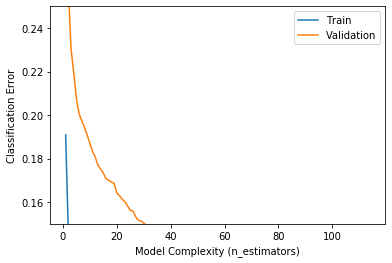

In [56]:
# 결과 시각화
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.15, 0.25))
plt.legend();

In [57]:
# 평가지표 확인 - 검증
print('검증 정확도', model.score(X_val_transformed, y_val))
print(classification_report(y_val, model.predict(X_val_transformed)))

검증 정확도 0.8681439680682679
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     12557
           1       0.53      0.27      0.36      1974

    accuracy                           0.87     14531
   macro avg       0.71      0.62      0.64     14531
weighted avg       0.84      0.87      0.85     14531



In [58]:
# 평가지표 확인 - 테스트
X_test_transformed = pipe_xg_re.named_steps['preprocessing'].transform(X_test)

print('테스트 정확도', model.score(X_test_transformed, y_test))
print(classification_report(y_test, model.predict(X_test_transformed)))

테스트 정확도 0.8679466006055602
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     12557
           1       0.53      0.28      0.36      1975

    accuracy                           0.87     14532
   macro avg       0.71      0.62      0.64     14532
weighted avg       0.84      0.87      0.85     14532



## **4. 모델 분석 및 최종 선택**

- **베이스라인 모델 결과**
1. 정확도 : 0.8692450622806414
2. F1-Score : 0.87
3. Target 1의 recall : 0.28

- **CV 모델 결과**
1. 정확도 : 0.8466831819432975
2. F1-Score : 0.85
3. Target 1의 recall : 0.34

- **XGboost 모델 결과(최종 모델로 선정)**
1. 정확도 : 0.8679466006055602
2. F1-Score : 0.87
3. Target 1의 recall : 0.28

- **Insight**
1. CV를 통해 일반화의 가능성을 기대하였지만(= 모델 성능 개선), 오히려 테스트 데이터의 정확도가 낮아짐으로써 일반화가 어렵다고 판단 됨
2. 이전에 언급한대로 수집 및 가공한 데이터 자체가 Target과의 연관성이 낮다고 판단되며, 이에따라 추가적인 GridSearchCV는 진행하지 않음으로 결정
3. 최종 모델을 XGBoost로 선정한 이유는 recall 값이 CV보다는 낮지만, CV모델의 정확도가 베이스라인보다 낮기 때문이며, 전체적인 성능을 고려하여 XGboost를 최종 모델로 선정 